We load the preprocessed dataset and use the train_val_test_split function defined in the file with the same name. We also drop the columns month and city since we want to predict in general, not for a specific city.

In [1]:
import pandas as pd
import numpy as np

In [2]:
weather_data = pd.read_csv('datasets/processed_dataset.csv')
weather_data = weather_data.drop(columns=['MONTH', 'CITY'])

In [3]:
from train_val_test_split import train_val_test_split
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(weather_data)

y_train = y_train.values.ravel()
y_val = y_val.values.ravel()
y_test = y_test.values.ravel()

We then fit a baseline model to our training data and evaluate it using F2 score on our validation set.

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import fbeta_score

baseline_svm_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(
        kernel="rbf",
        C=1,
        gamma="scale",
        class_weight="balanced"
    ))
])

baseline_svm_pipe.fit(X_train, y_train.ravel())
y_pred_base = baseline_svm_pipe.predict(X_val)

baseline_f2 = fbeta_score(y_val, y_pred_base, beta=2)
print(f"Baseline f2 score: {baseline_f2}")

Baseline f2 score: 0.8034036910155818


Then we do a grid search to try and find the best hyperparameters for our model.

In [5]:
C_values = [0.1, 1, 10]
gamma_values = ["scale", 0.01, 0.1, 1]

results = []

for C in C_values:
    for gamma in gamma_values:
        svm_pipe = Pipeline([
            ("scaler", StandardScaler()),
            ("svm", SVC(
                kernel="rbf",
                C=C,
                gamma=gamma,
                class_weight="balanced",
            ))
        ])

        svm_pipe.fit(X_train, y_train)

        y_val_pred = svm_pipe.predict(X_val)
        f2 = fbeta_score(y_val, y_val_pred, beta=2)

        results.append({
            "C": C,
            "gamma": gamma,
            "f2": f2
        })

In [6]:
best_param = max(results, key=lambda x: x["f2"])
best_param

{'C': 0.1, 'gamma': 0.01, 'f2': 0.8233238698405766}

We then train the model with the best hyperparameters on the trainval set and compare this to the test set for performance

In [7]:
X_trainval = pd.concat([X_train, X_val])
y_trainval = np.hstack([y_train, y_val])

best_model_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(
        kernel="rbf",
        C=0.1,
        gamma=0.01,
        class_weight="balanced",
    ))
])

best_model_pipe.fit(X_trainval, y_trainval)
y_best_model_pred = best_model_pipe.predict(X_test)
f2_final_model = fbeta_score(y_test, y_best_model_pred, beta=2)
print(f"The f2 score for the final model is {f2_final_model}")

The f2 score for the final model is 0.8113988537465506


We also plot a ROC curve and compute the auc for the ROC curve for the baseline model and final model

In [8]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

baseline_scores = baseline_svm_pipe.decision_function(X_test)
final_scores = best_model_pipe.decision_function(X_test)

fpr_base, tpr_base, _ = roc_curve(y_test, baseline_scores)
fpr_final, tpr_final, _ = roc_curve(y_test, final_scores)

auc_base = roc_auc_score(y_test, baseline_scores)
auc_final = roc_auc_score(y_test, final_scores)

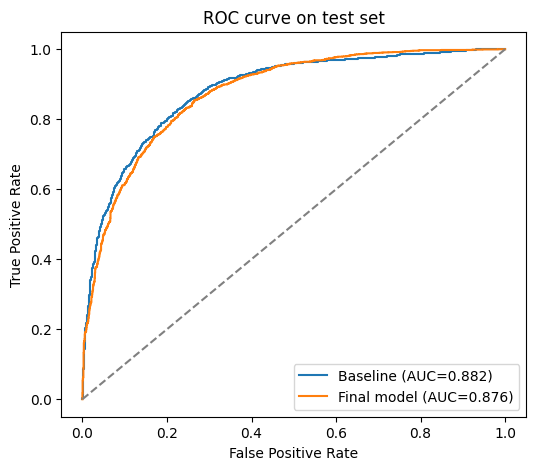

The area under curve for baseline: 0.8823754346310949
The area under curve for final model: 0.8759280021772258


In [9]:
plt.figure(figsize=(6, 5))
plt.plot(fpr_base, tpr_base, label=f"Baseline (AUC={auc_base:.3f})")
plt.plot(fpr_final, tpr_final, label=f"Final model (AUC={auc_final:.3f})")
plt.plot([0, 1], [0, 1], "--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve on test set")
plt.legend()
plt.show()

print(f"The area under curve for baseline: {auc_base}")
print(f"The area under curve for final model: {auc_final}")

A final check for overfitting: compare trainval to test data and also check train against validation to check if no overfitting occurs while training the model

In [10]:
y_trainval_pred = best_model_pipe.predict(X_trainval)
y_test_pred = best_model_pipe.predict(X_test)
f2_trainval = fbeta_score(y_trainval, y_trainval_pred, beta=2)
f2_test = fbeta_score(y_test, y_test_pred, beta=2)

In [11]:
print(f2_trainval - f2_test)

0.00987407894834369


In [12]:
y_train_pred = best_model_pipe.predict(X_train)
y_val_pred = best_model_pipe.predict(X_val)
f2_train = fbeta_score(y_train, y_train_pred, beta=2)
f2_val = fbeta_score(y_val, y_val_pred, beta=2)

In [13]:
print(f2_train - f2_val)

-0.004485692113165962
